In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import hydrobr
import geobr
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable 
# import matplotlib.gridspec as gridspec
# from matplotlib import colors
# import plotly.express as px
from datetime import datetime, timedelta
from scipy.spatial import KDTree
from math import radians, sin, cos, sqrt, atan2

c:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
# Caminhos dos diretórios raiz
# general_path = 'C:/Users/cnalm/OneDrive/Hidroweb'
# general_path = 'D:/Dados_Nuvem/OneDrive/Hidroweb'
general_path = r'C:\Users\linde\OneDrive\Hidroweb'


In [4]:
def getNearestGauge(row):
    lat = row['Latitude']
    lon = row['Longitude']
    code = row['Code']
    df_local = df_temp[df_temp['Code'] != code]
    locations = df_local[['Latitude', 'Longitude']].values
    kdtree = KDTree(locations)
    distances, indices = kdtree.query([lat, lon], k=1)
    # Get the values at the nearest stations
    # nearest_latitude = df_coords.iloc[indices]['Latitude']
    # nearest_longitude = df_coords.iloc[indices]['Longitude']
    # gauge_code_list = []
    # for i in indices:
    #     gauge_code_list.append(df_temp.iloc[i]['Code'])
    gauge_code = df_local.iloc[indices]['Code']
    # distance = df_temp.iloc[distances[1]]['Code']
    # print("code", code, distances, "\gauge_code", gauge_code, "\ndistance", distance)
    # print(len(df_temp))
    # print(len(df_local))
    return gauge_code

In [5]:
def haversine_distance(row):
    lat1 = row['Latitude']
    lon1 = row['Longitude']
    lat2 = row['Nearest_Lat']
    lon2 = row['Nearest_Lon']

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    # Earth radius in kilometers
    R = 6371.0

    # Calculate the distance
    distance = R * c

    return distance

In [6]:
def createMap(df):
    plt.style.use("ggplot")
    SHP = gpd.read_file(general_path + '/SHP/Brazilian_Border.shp')
    br_map = geobr.read_state(year = 2020)
    br_map.crs = "EPSG:4326"
    br_map['name_state'] = br_map['name_state'].apply(str.upper)
    br_map = br_map.sort_values(by = ['name_state'])
    br_map['name_state'].replace({'AMAZÔNAS': 'AMAZONAS'}, inplace = True)
    
    plt.rcParams['font.size'] = '14'
    plt.rcParams["font.family"] = "Times New Roman"
    tnr_title = {'fontname':'Times New Roman', "fontweight" :"bold", 'fontsize': 16}

    # Create a common color map and normalization
    cmap =  'viridis_r' # You can choose a different colormap if desired
    norm = plt.Normalize(0.0, 500.0)

    fig, ax = plt.subplots(figsize = (10, 7))
    SHP.plot(ax = ax, color = 'w')
    br_map.plot(ax = ax, color = 'white', edgecolor = 'black')
    df.plot(ax = ax
            , column = 'Nearest_Distance'
            , legend = True
            , cmap = cmap
            , norm = norm
            , alpha = 1.0
            , markersize = df['Nearest_Distance']
            )

                    
    ax.set_title("Nearest Neighbor Distance (km) by gauge ("+start_year+' - '+end_year+")", tnr_title)

    # fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(df['Nearest_Distance'].min(), df['Nearest_Distance'].max()), cmap='viridis_r'),
    #             ax=ax, orientation='vertical', label='Nearest Neighbor Distance (km)')

    # Add colorbar
    # cbar = plt.colorbar(scatter1, label='Nearest Neighbor Distance (km)')

    ax.set_ylim([-35, 7])
    ax.set_xlim([-75, -30])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.grid(ls='--')
    plt.tight_layout()
    plt.savefig(general_path +'/Figures/nearest_neighbor_gauges_'+start_year+'_'+end_year+'.jpeg', format='jpeg', dpi=1200, transparent=False, bbox_inches=None)
    plt.show()
    plt.close()

In [7]:
def add_10_years(input_date):

    # Add 10 years to the input date
    result_datetime = input_date + timedelta(days=3652)  # Considering leap years

    # Format the result date as a string
    result_date = result_datetime.strftime("%Y-%m-%d")

    return result_date

In [8]:
df_gauges = pd.read_hdf(general_path + '/Consolidated Files/BRASIL_INTERPOLATED_VALUES_CONSOLIDATION_1961_2020_REDUCED_V2.h5')
df_gauges = df_gauges[['Date','Code']].drop_duplicates().reset_index(drop = True)
df_gauges

,Date,Code
0,1961-01-01,00048000
1,1961-01-01,00062000
2,1961-01-01,00067000
3,1961-01-01,00145004
4,1961-01-01,00148001
...,...,...
101961834,2020-12-31,03151003
101961835,2020-12-31,03155001
101961836,2020-12-31,03252008
101961837,2020-12-31,03252025


In [9]:
df_all_gauges = hydrobr.get_data.ANA.list_prec_stations() 
df_all_gauges = df_all_gauges[['Code', 'Latitude', 'Longitude']]
df_neighbor = df_all_gauges.copy(deep = True)
df_neighbor.columns = ['Nearest_Code', 'Nearest_Lat', 'Nearest_Lon']
df_neighbor

,Nearest_Code,Nearest_Lat,Nearest_Lon
0,00047000,-0.6500,-47.5500
1,00047002,-0.6231,-47.3536
2,00047003,-0.7375,-47.8536
3,00047004,-0.9294,-47.0994
4,00047005,-0.6336,-47.6583
...,...,...,...
11971,08461000,4.4883,-61.1297
11972,08464001,4.0031,-64.4431
11973,08555060,5.8000,-55.1667
11974,08555096,5.4700,-55.2000


In [10]:
date_list = pd.date_range(start='1961-01-01', end='2011-01-01', freq='10AS')
# Convert the pandas Index to a list
date_list = date_list.tolist()
date_list = [date.date() for date in date_list]
date_list

[datetime.date(1961, 1, 1),
 datetime.date(1971, 1, 1),
 datetime.date(1981, 1, 1),
 datetime.date(1991, 1, 1),
 datetime.date(2001, 1, 1),
 datetime.date(2011, 1, 1)]

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:33: ShapelyDepreca

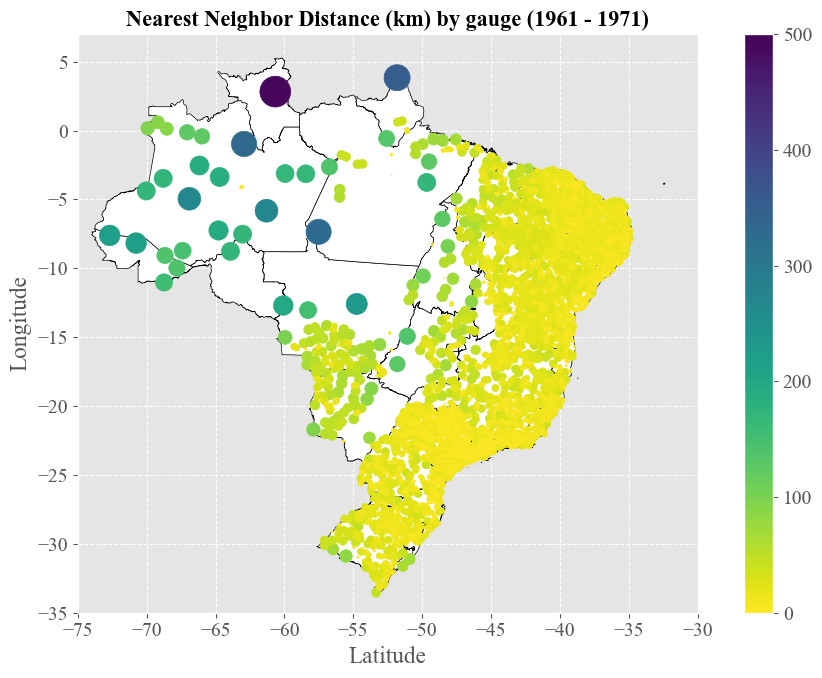

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\anaconda3\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecat

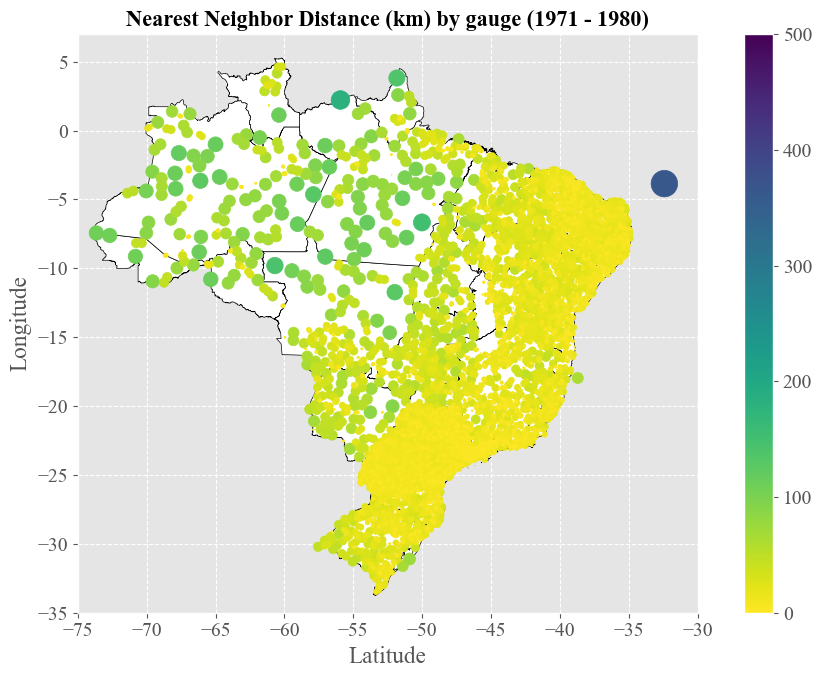

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\anaconda3\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecat

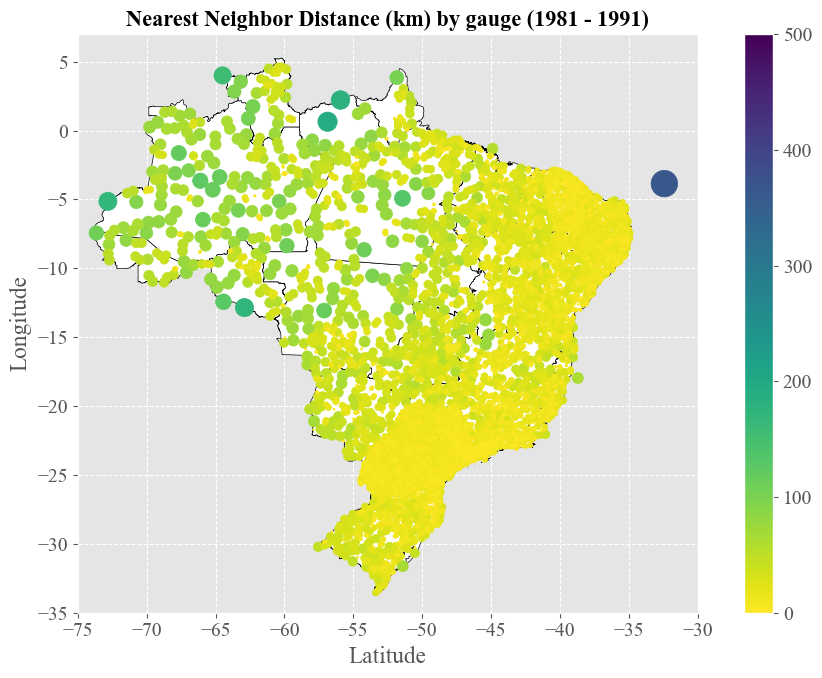

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\anaconda3\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecat

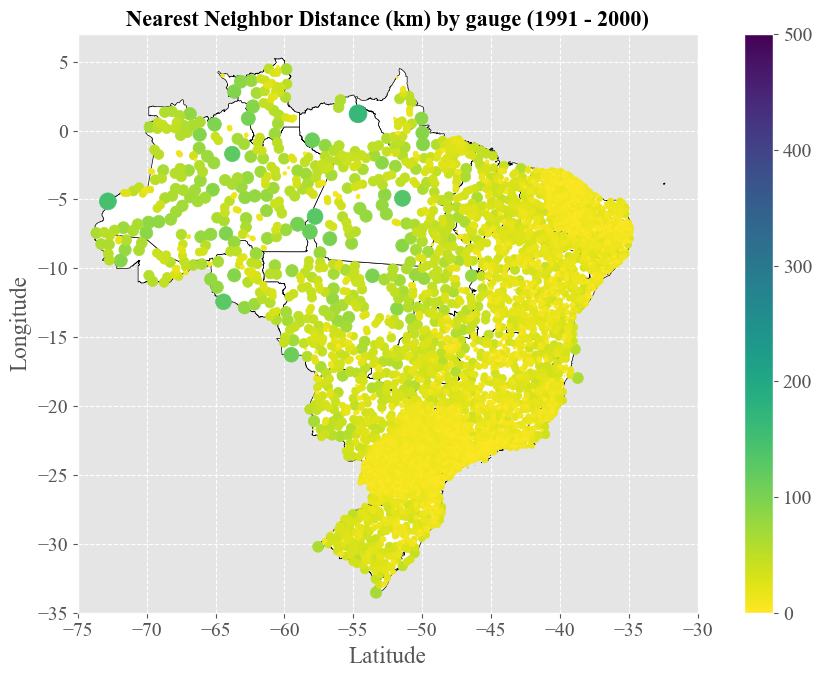

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\anaconda3\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecat

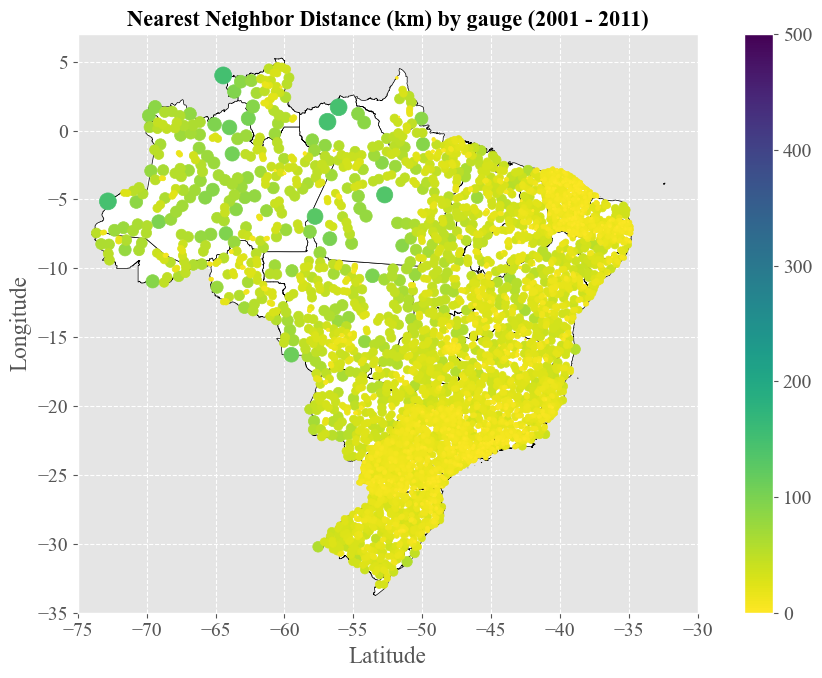

C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:34: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  out = from_shapely(data)
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
C:\Users\linde\AppData\Roaming\Python\Python311\site-packages\geopandas\plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
c:\anaconda3\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecat

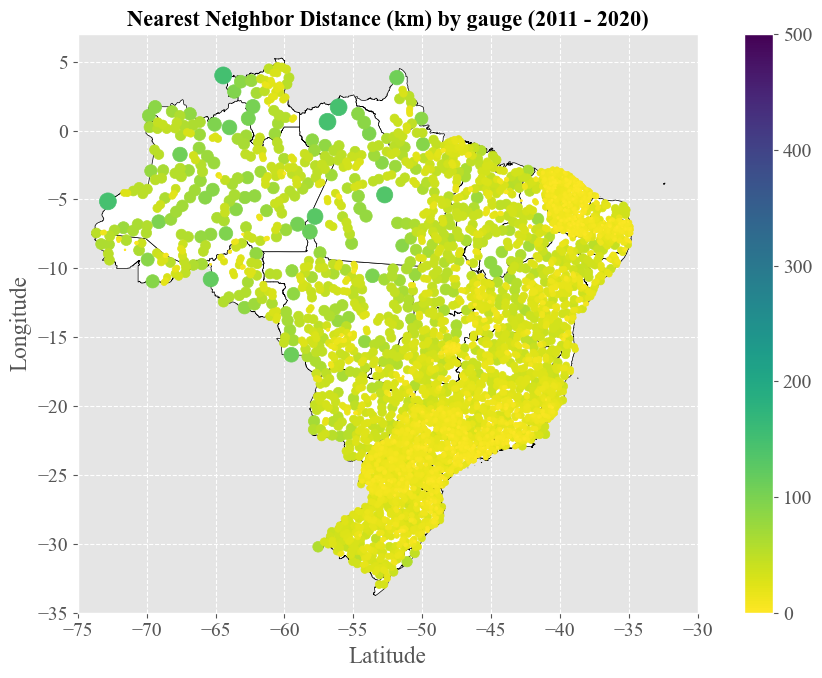

In [11]:
df_result = pd.DataFrame([])
for start_date in date_list:
    end_date = add_10_years(start_date)
    # print(start_date, end_date)
    start_year = str(start_date)[:4]
    end_year = str(end_date)[:4]
    # print(start_year, end_year)
    start_datetime = datetime.strptime(str(start_date), '%Y-%m-%d')
    end_datetime = datetime.strptime(str(end_date), '%Y-%m-%d')
    # print(start_datetime, end_datetime)
    df_temp = df_gauges[(df_gauges['Date'] >= start_datetime) & (df_gauges['Date'] < end_datetime)]
    df_temp = pd.merge(df_temp, df_all_gauges, on = 'Code', how = 'left')
    df_temp = df_temp[['Code', 'Latitude', 'Longitude']].drop_duplicates(ignore_index=True)
    df_temp['Nearest_Code'] = df_temp.apply(getNearestGauge, axis=1)
    df_gauge_nearest = pd.merge(df_temp, df_neighbor, on='Nearest_Code', how = 'left')
    df_gauge_nearest['Nearest_Distance'] = df_gauge_nearest.apply(haversine_distance, axis=1)
    df_gauge_nearest['Decade_Start'] = int(start_year)
    df_gauge_nearest['Decade_End'] = int(end_year)
    if len(df_result) > 0:
        df_result = pd.concat([df_result, df_gauge_nearest], ignore_index = True)
    else:
        df_result = df_gauge_nearest.copy(deep = True)
    geometry = gpd.points_from_xy(df_gauge_nearest['Longitude'], df_gauge_nearest['Latitude'])
    df_gauge_nearest = gpd.GeoDataFrame(df_gauge_nearest, geometry=geometry, crs="EPSG:4326")
    df_gauge_nearest.sort_values(['Nearest_Distance'], ascending=False, inplace=True, ignore_index=True)
    df_gauge_nearest.dropna(inplace=True)
    createMap(df_gauge_nearest)

In [12]:
df_result

,Code,Latitude,Longitude,Nearest_Code,Nearest_Lat,Nearest_Lon,Nearest_Distance,Decade_Start,Decade_End
0,00048000,-0.7278,-48.5158,00049001,-0.61670,-49.1667,73.418598,1961,1971
1,00062000,-0.9711,-62.9286,00364000,-3.36670,-64.7000,331.200472,1961,1971
2,00067000,-0.1253,-67.0611,00065000,-0.42000,-65.9800,124.597687,1961,1971
3,00145004,-1.6678,-45.3683,00145005,-1.66667,-45.3667,0.217747,1961,1971
4,00148001,-1.4500,-48.5000,00148002,-1.43500,-48.4378,7.112468,1961,1971
...,...,...,...,...,...,...,...,...,...
37642,00338079,-3.7431,-38.5519,00338001,-3.75000,-38.5833,3.567538,2011,2020
37643,02648019,-26.7550,-48.6994,02648020,-26.56170,-48.7192,21.583852,2011,2020
37644,00438124,-4.2261,-38.0900,00438067,-4.21670,-38.1167,3.139927,2011,2020
37645,01538008,-15.6833,-38.9500,01538001,-15.87060,-38.8886,21.838567,2011,2020
